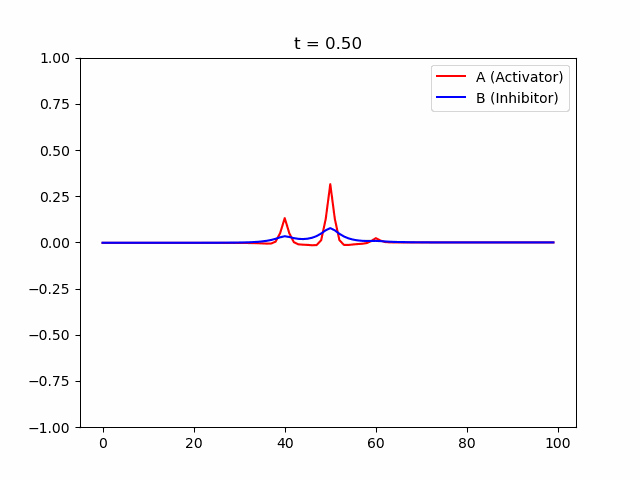

In [1]:
# Model 3: Asymmetrical Cell Division and Differential Inhibition
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image

class BaseStateSystem:
    pass

def laplacian1D(data, dx):
    """Computes a 1D Laplacian using finite differences."""
    lap = np.zeros_like(data)
    lap[1:-1] = (data[2:] - 2 * data[1:-1] + data[:-2]) / (dx**2)
    return lap

def central_apical_initialiser(shape):
    """Start with one apical cell in the center, left grows first, right is delayed."""
    a = np.zeros(shape)
    b = np.zeros(shape)

    center = shape // 2
    left = center - 10  # Slightly offset to the left
    right = center + 10  # Slightly offset to the right
    
    # Initial apical cell in the center
    a[center] = 0.5  # Strong apical identity in the center

    # **Left Peak Forms First**
    a[left] = 0.2  # Early activation on the left

    # **Right Peak Initially Suppressed**
    a[right] = 0.05  # Weak activation on the right, still suppressed

    # **Strong Asymmetric Inhibition**
    inhibition = np.ones(shape)
    inhibition[right:] = 0.05  # STRONG suppression on the right
    inhibition[:left] = 0.9  # Early release of left-side growth

    return a, b, inhibition, center, right  # Return inhibition array and key indices

class OneDimensionalRDEquations(BaseStateSystem):
    def __init__(
        self, Da, Db, Ra, Rb,
        initialiser=central_apical_initialiser,
        width=1000, dx=1, 
        dt=0.1, steps=1
    ):
        self.Da = Da
        self.Db = Db
        self.Ra = Ra
        self.Rb = Rb
        self.initialiser = initialiser
        self.width = width
        self.dx = dx
        self.dt = dt
        self.steps = steps
        
    def initialise(self):
        self.t = 0
        self.a, self.b, self.inhibition, self.center, self.right_index = self.initialiser(self.width)  # Get inhibition array and indices
        
    # Loops self.steps times and increments the simulation time self.t by dt
    def update(self):
        for _ in range(self.steps):
            self.t += self.dt
            self._update()

    def _update(self):
        a, b = self.a, self.b
        Da, Db = self.Da, self.Db
        Ra, Rb = self.Ra, self.Rb
        dt, dx = self.dt, self.dx
        
        La = laplacian1D(a, dx)
        Lb = laplacian1D(b, dx)

        # Apply reaction-diffusion equations with inhibition
        delta_a = dt * (Da * La + Ra(a, b) * self.inhibition) # Da*La causes a to spread out; a is modualted by an inhibition factor
        delta_b = dt * (Db * Lb + Rb(a, b)) # Similar update to above but without the additional inhibtion modulation

        self.a += delta_a
        self.b += delta_b

        # Strong suppression on the right until the peak is growing
        left_threshold = 0.4  # Left must reach this to unlock right
        if np.max(a[: self.center]) > left_threshold:  # Left side is large enough
            self.inhibition[self.right_index:] += 0.001  # Slowly allow right side to activate

        # Keep inhibition between [0,1] so it doesn't become too high or low
        self.inhibition = np.clip(self.inhibition, 0, 1)

    def draw(self, ax):
        ax.clear()
        ax.plot(self.a, color="r", label="A (Activator)")
        ax.plot(self.b, color="b", label="B (Inhibitor)")
        ax.legend()
        ax.set_ylim(-1, 1)
        ax.set_title(f"t = {self.t:.2f}")

    def plot_time_evolution(self, filename, n_steps=150, fps=10):
        self.initialise()
        
        fig, ax = plt.subplots()

        def update_frame(i):
            self.update()
            self.draw(ax)

        anim = FuncAnimation(
            fig,
            update_frame,
            frames=n_steps,
            interval=50, 
            repeat=False
        )
        
        # Explicitly use Pillow (no ImageMagick)
        writer = PillowWriter(fps=fps)
        anim.save(filename, writer=writer)
        plt.close(fig)

# Usage
Da, Db, alpha, beta = 1, 100, -0.005, 10

def Ra(a, b): return a - a**3 - b + alpha
def Rb(a, b): return (a - b) * beta

width = 100
dx = 1
dt = 0.001

system = OneDimensionalRDEquations(
    Da, Db, Ra, Rb,
    initialiser=central_apical_initialiser,
    width=width,
    dx=dx,
    dt=dt,
    steps=250
)

# Generate the animation
system.plot_time_evolution("1dRD_central_apical.gif", n_steps=150)

# Display the GIF inline in Jupyter
Image("1dRD_central_apical.gif")